In [1]:
import os

os.environ["SEED"] = "0"
os.environ["TRAIN_DIR"] = "TRAIN"

from src.constant import DATA_DIR, DATABASE_DIR
from src.database.queries import *
from src.instance.InstanceList import InstanceList
from src.instance.TSP_Instance import TSP_from_index_file
from src.solver.Portfolio import Portfolio
from src.solver.TSP_LKH_Solver import TSP_LKH_Solver

In [4]:
generator_to_i = {
    "cluster_netgen": 0,
    "comperssion": 200,
    "expansion": 400,
    "explosion": 600,
    "grid": 800,
}
i = generator_to_i["grid"]

instances = TSP_from_index_file(
    filepath=DATA_DIR / "TSP" / "TRAIN" / "index.json",
    max_cost=3000.0,
    max_time=300.0,
)
instances = instances[i + 14 : i + 20]
instances

InstanceList(size=6)[TSP_Instance(filepath=TSP/TRAIN/grid/014.tsp), TSP_Instance(filepath=TSP/TRAIN/grid/015.tsp), TSP_Instance(filepath=TSP/TRAIN/grid/016.tsp), TSP_Instance(filepath=TSP/TRAIN/grid/017.tsp), TSP_Instance(filepath=TSP/TRAIN/grid/018.tsp), TSP_Instance(filepath=TSP/TRAIN/grid/019.tsp)]

In [2]:
db = DB(DATABASE_DIR / "run-phase1-dataset-993244.db")

In [20]:
results = pd.read_sql_query("SELECT * FROM results", db._conn)

(array([4413., 1746., 1422., 1285., 1103.,  938.,  877.,  787.,  756.,
        4413.]),
 array([0.        , 0.57330707, 1.14661414, 1.71992121, 2.29322827,
        2.86653534, 3.43984241, 4.01314948, 4.58645655, 5.15976362,
        5.73307069]),
 <BarContainer object of 10 artists>)

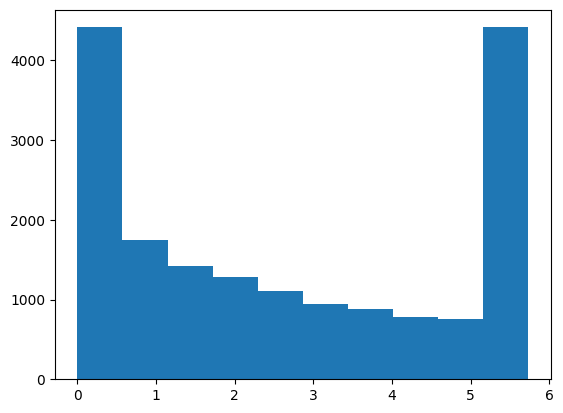

In [29]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(np.log(results["time"] + 1))

In [10]:
os.environ["generator"] = "grid"


In [12]:
generator = os.environ.get("generator").strip()
generator_to_i = {
    "cluster_netgen": 0,
    "comperssion": 200,
    "expansion": 400,
    "explosion": 600,
    "grid": 800,
}
i = generator_to_i[generator]
instances = TSP_from_index_file(
    filepath=DATA_DIR / "TSP" / "TRAIN" / "index.json",
    max_cost=3000.0,
    max_time=300.0,
)

instances = instances[i:i+20]

In [8]:
N = 100

instances = TSP_from_index_file(
    filepath=DATA_DIR / "TSP" / "TRAIN" / "index.json",
    max_cost=3000.0,
    max_time=300.0,
)

instances[800]

TSP_Instance(filepath=TSP/TRAIN/grid/000.tsp)

In [3]:
portfolio = Portfolio.from_solver_class(TSP_LKH_Solver, size=500)

In [ ]:
portfolio.evaluate(
    instance_list=instances,
    prefix="dataset",
    calculate_features=True,
    cache=True
)

[2025-03-17 23:05:23] DEBUG     Portfolio.evaluate(dataset)
[2025-03-17 23:05:23] DEBUG     Portfolio(size=500)[Solver(id=52980316141715150), Solver(id=473831520656465062), Solver(id=2058572598820127428), Solver(id=85558984741464718), Solver(id=1627157478422782408), Solver(id=960146198466077527), Solver(id=1749821957932695904), Solver(id=1823868260515018505), Solver(id=1000342069507652021), Solver(id=1298263449298399145), Solver(id=796686204501835823), Solver(id=277732223524031859), Solver(id=234889156279032954), Solver(id=243551108109002071), Solver(id=841112101883113817), Solver(id=55073102298775204), Solver(id=928790781331301787), Solver(id=526730673442330645), Solver(id=1341059070128019045), Solver(id=990737851297008821), Solver(id=655916849093964892), Solver(id=1259504250925769354), Solver(id=779128029359967983), Solver(id=1116692679944401361), Solver(id=1583601300928187750), Solver(id=301545267790225386), Solver(id=2053435627873114273), Solver(id=2254589839766803656), Solver(id=2

In [4]:
db = DB(DATABASE_DIR / "test-2025_03_17_23_05_17.db")
pd.read_sql("SELECT * FROM solvers", db._conn)

,id,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,EXTRA_CANDIDATE_SET_TYPE,GAIN23,GAIN_CRITERION,INITIAL_STEP_SIZE,...,MAX_BREADTH,MAX_CANDIDATES,MOVE_TYPE,PATCHING_A,PATCHING_C,POPULATION_SIZE,RESTRICTED_SEARCH,SUBGRADIENT,SUBSEQUENT_MOVE_TYPE,SUBSEQUENT_PATCHING
0,52980316141715150,0.60,1.0,0.0,0.0,0.7,0.0,1.0,0.0,0.00,...,0.444643,1.000000,0.25,0.6,0.2,0.061224,0.0,0.0,5.0,1.0
1,473831520656465062,0.25,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.50,...,0.470388,0.888889,1.00,0.6,0.2,0.244898,0.0,1.0,3.0,1.0
2,2058572598820127428,0.90,1.0,0.0,3.0,0.6,0.0,1.0,0.0,1.00,...,0.343259,0.555556,0.00,0.6,0.8,0.357143,1.0,1.0,5.0,0.0
3,85558984741464718,0.90,1.0,0.0,3.0,0.6,0.0,0.0,0.0,0.00,...,0.615161,0.444444,0.50,0.8,0.4,0.265306,0.0,1.0,0.0,1.0
4,1627157478422782408,0.10,0.0,0.0,1.0,0.3,0.0,0.0,0.0,0.25,...,0.066931,0.111111,0.50,0.2,0.8,0.520408,1.0,0.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,864738382189503080,0.45,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.75,...,0.516131,0.333333,1.00,1.0,0.4,0.193878,1.0,0.0,2.0,0.0
496,1671347939346131212,0.95,0.0,1.0,3.0,1.0,0.0,1.0,1.0,0.25,...,0.054530,0.222222,0.75,0.8,0.0,0.908163,0.0,0.0,3.0,1.0
497,2294257882938389069,1.00,0.0,0.0,1.0,0.5,0.0,1.0,1.0,0.25,...,0.086354,0.777778,0.00,0.0,1.0,0.397959,0.0,1.0,5.0,1.0
498,1680882904861884988,0.55,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.75,...,0.491769,0.333333,0.00,0.4,0.6,0.673469,1.0,1.0,4.0,1.0
